# VAE on ModelNet for scene completion

Imports and setup

In [1]:

import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

import torch
import torch.nn as nn
import torch.distributions as td
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm
import pickle
from sklearn.decomposition import PCA

In [2]:
sys.path.append('/home/benjamin.deporte/MVA/MVA_ModelNet_VAE/')

from libs import dataset

In [3]:
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

if use_cuda:
    print(f"Using GPU") 
else:
    print(f"Using CPU")

Using GPU


Import dataset and form dataloader

In [4]:
# uses datasets and Dataset class from https://github.com/antao97/PointCloudDatasets/

# parameters :
# root : root directory, must contain file dataset_name + '_hdf5_2048
# dataset_name : modelnet10 par défaut, sinon modelnet40
# class_choice : permet de ne sélectionner qu'une classe
# split : 'train' par défaut. valeurs possibles = 'test', 'trainval', 'all', etc.
# possibilité de data augmentation également

modelnet10 = dataset.Dataset(root='/home/benjamin.deporte/MVA/MVA_ModelNet_VAE/data/', split='all', load_name=True)
modelnet40 = dataset.Dataset(root='/home/benjamin.deporte/MVA/MVA_ModelNet_VAE/data/', split='all', dataset_name='modelnet40')

In [5]:
print(f"ModelNet10 dataset has {len(modelnet10)} elements")
print(f"ModelNet40 dataset has {len(modelnet40)} elements")

ModelNet10 dataset has 4899 elements
ModelNet40 dataset has 12311 elements


In [6]:
batch_size = 4

In [7]:
mn10_loader = DataLoader(
    modelnet10,
    batch_size=batch_size,
    shuffle=True
    )

mn10_iter = iter(mn10_loader)

In [8]:
# outputs : normalized tensors of 2048 points (x,y,z)

point_set, label, name, file = next(mn10_iter)

print(f"point set = {point_set.shape}")
print(f"label = {label}")
print(f"name = {name}")
print(f"file = {file}")

point set = torch.Size([4, 2048, 3])
label = tensor([[1],
        [1],
        [2],
        [9]])
name = ('bed', 'bed', 'chair', 'toilet')
file = ('bed/bed_0562.ply', 'bed/bed_0055.ply', 'chair/chair_0416.ply', 'toilet/toilet_0370.ply')


Some visualisation

In [9]:
def display_points_list(points_list, name="inconnu"):
    """Display points list

    Args:
        points_list (torch.tensor): torch.tensor shape 2048 x 3
    """
    
    data = points_list.numpy().reshape(2048,3)
    df = pd.DataFrame(data=data, columns=['X','Y','Z'])
    fig = px.scatter_3d(df, x='X', y='Y', z='Z', opacity=0.2, symbol_sequence=['cross'], title=f"{name}")
    
    return fig

In [10]:
for tensor_pc in range(2):
    batch_ps, batch_labels, batch_names, _ = next(mn10_iter)
    for i in range(batch_size):
        ps = batch_ps[i]
        label = batch_labels[i]
        name = batch_names[i]
        fig = display_points_list(ps, name)
        fig.show()

Hyperparameters

In [11]:
# size of the cube
NX = 16
NY = 16
NZ = 16
p = NX*NY*NZ

### Data Conversion utility functions

Class to navigate between point clouds as list of (x,y,z) and tensor (NX,NY,NZ) of 0's and 1's

In [12]:

class PointCloud():
    """Utility class to handle point cloud
    Manages two views :
    - a list of 2048 points (x,y,z) normalized within [-1,1]^3, as out of the ModelNet datasets
    - a 3D tensor of NX x NY x NZ shape
    """
    
    def __init__(self, nx=NX, ny=NY, nz=NY, from_list=None, from_3d_tensor=None):
        self.nx = nx
        self.ny = ny
        self.nz = nz
        assert ((from_list != None) or (from_3d_tensor != None)), "need to choose between points list and 3d tensor"
        if from_list != None:
            # input is a 3D tensor shape 2048 x 3 : list of points
            self.points_list = from_list
            self.tensor_3d = None
        else:
            # input is a 3D tensor (nx x ny x nz) of 0 or 1s
            self.tensor_3d = from_3d_tensor
            self.points_list = None
        self.dx = 2 / self.nx
        self.dy = 2 / self.ny
        self.dz = 2 / self.nz
    
    def set_points_list(self):
        # assumes that self.tensor_3d exists
        # create the points_list view
        self.points_list = torch.zeros((2048,3))
        index = 0
        for i in range(self.nx):
            cx = -1 + (2*i+1)*self.dx/2
            for j in range(self.ny):
                cy = -1 + (2*j+1)*self.dy/2
                for k in range(self.nz):
                    cz = -1 + (2*k+1)*self.dy/2
                    n_points = self.tensor_3d[i,j,k]
                    if n_points >= 1:
                        for l in range(n_points):
                            # add points of ccorodinates (cx,cy,cz) to the points list
                            self.points_list[index,0] = cx
                            self.points_list[index,1] = cy
                            self.points_list[index,2] = cz
                            index += 1
    
    def set_3d_tensor(self):
        # assumes that self.points_list exists
        # create the 3d_tensor view
        self.tensor_3d = torch.zeros((self.nx, self.ny, self.nz))
        for i in range(self.points_list.shape[0]):
            # get next point in the list
            x = self.points_list[i,0]
            y = self.points_list[i,1]
            z = self.points_list[i,2]
            # get coordinates in the 3D tensor
            # ix = int(np.floor((x+1)/self.dx)) ... not cuda type error ...
            # iy = int(np.floor((y+1)/self.dy))
            # iz = int(np.floor((z+1)/self.dz))
            ix = int(torch.floor((x+1)/self.dx).item())
            if ix < 0: ix=0
            if ix >= self.nx: ix = self.nx-1
            
            iy = int(torch.floor((y+1)/self.dy).item())
            if iy < 0: iy=0
            if iy >= self.ny: iy = self.ny-1
            
            iz = int(torch.floor((z+1)/self.dz).item())
            if iz < 0: iz=0
            if iz >= self.nz: iz = self.nz-1
            
            self.tensor_3d[ix,iy,iz] = 1
    
    def get_points_list(self):
        return self.points_list
    
    def get_3d_tensor(self):
        return self.tensor_3d
    
    def __repr__(self):
        msg = f"Point Cloud instance\n"
        msg += f"Points list view : {self.points_list}\n"
        msg += f"3D tensor view : {self.tensor_3d}\n"
        return msg

In [13]:
ps.shape

pc = PointCloud(from_list=ps)

In [14]:
pc.get_points_list()

tensor([[-0.3084, -0.1210, -0.1019],
        [ 0.3521,  0.6040,  0.4959],
        [ 0.3972, -0.6709, -0.6261],
        ...,
        [-0.1359,  0.3524,  0.3454],
        [-0.1857,  0.1166,  0.2552],
        [-0.3980, -0.3650, -0.6024]])

In [15]:
display_points_list(pc.get_points_list(), "quelconque")

In [16]:
# get the view as 3D tensor
pc.set_3d_tensor()

In [17]:
def display_3d_tensor(tensor_3d, name="quelconque"):
    """Display point cloud with tensor 3d (NX x NY x NZ) as input

    Args:
        tensor_3d (tensor): Torch tensor shape NX x NY x NZ
        name (str, optional): string à afficher comme titre. Defaults to "inconnu".
    """
    
    xs = []
    ys = []
    zs = []
    for i in range(NX):
        for j in range(NY):
            for k in range(NZ):
                n = tensor_3d[i,j,k]
                if n >= 1:
                    xs.append(i)
                    ys.append(j)
                    zs.append(k)
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(xs,ys,zs,marker='.')
    ax.set_xlim(left=0, right=NX)
    ax.set_ylim(bottom=0, top=NY)
    ax.set_zlim(bottom=0, top=NZ)
    ax.set_title(name)
    
    return fig

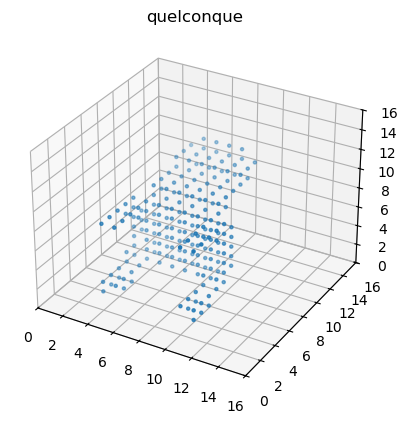

In [18]:
fig = display_3d_tensor(pc.get_3d_tensor())

### Converting the datasets from list points to tensors 3D

In [19]:
def convert_batch_to_tensors_3d(batch_points_list):
    """Converts a tensor (batch_size x (2048 x 3)) points cloud
    in a batch (batch_size x (NX,NY,NZ))

    Args:
        batch_points_list (torch.tensor): batch_szie tensors of shape (2048 x 3)
    Returns:
        batch_size 3D_tensors of shape (NX,NY,NZ) of 0s and 1s
    """
    
    batch_dim = batch_points_list.shape[0]
    batch_tensors_3d = torch.zeros((batch_dim,NX,NY,NZ))
    for i in range(batch_dim):
        point_list = batch_points_list[i]
        pc = PointCloud(from_list = point_list, nx=NX, ny=NY, nz=NZ)
        pc.set_3d_tensor()
        tensor_3d = pc.get_3d_tensor()
        batch_tensors_3d[i] = tensor_3d
        
    return batch_tensors_3d

In [20]:
mn10_iter = iter(mn10_loader)

for tensor_pc in range(1):
    # outputs :
    # batch_ps = batch_size x 2048 x 3 (torch.tensor)
    # batch_labels = batch_size x 1 (troche.tensor)
    batch_ps, batch_labels, _, _ = next(mn10_iter)
    print(f"batch_ps = {batch_ps.shape}")
    
    batch_tensors_3d = convert_batch_to_tensors_3d(batch_ps)
    print(f"batch converti tensors_3d = {batch_tensors_3d.shape}")

batch_ps = torch.Size([4, 2048, 3])
batch converti tensors_3d = torch.Size([4, 16, 16, 16])


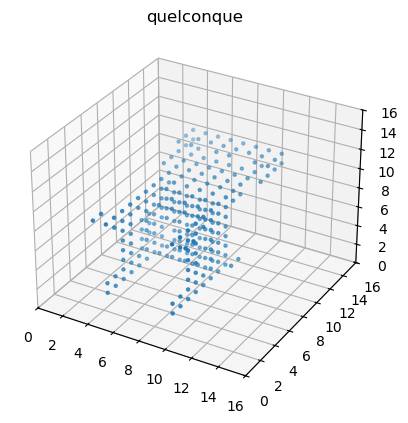

In [21]:
# check
i = 2

fig = display_3d_tensor(batch_tensors_3d[i])

In [22]:
fig = display_points_list(batch_ps[i])
fig.show()

In [23]:
# original format dataset : points list (2048 x 3)
modelnet10 = dataset.Dataset(root='/home/benjamin.deporte/MVA/MVA_ModelNet_VAE/data/', split='all', load_name=True)
modelnet40 = dataset.Dataset(root='/home/benjamin.deporte/MVA/MVA_ModelNet_VAE/data/', split='all', dataset_name='modelnet40')

In [36]:
# Converting ModelNet10 to ModelNet10_converted : tensors 3D : (NX,NY,NZ) of 0s and 1s

mn10_loader = DataLoader(
    modelnet10,
    batch_size=batch_size,
    shuffle=True
    )

# mn10_iter = iter(mn10_loader)
l = len(mn10_loader)
modelnet10_converted_dataset = None

# UNCOMMENT TO RUN THE CONVERSION

# for i, (point_set, label, name, file) in enumerate(mn10_loader):
#     point_set_to_tensors_3d = convert_batch_to_tensors_3d(point_set)
#     if modelnet10_converted_dataset is None:
#         modelnet10_converted_dataset = torch.utils.data.TensorDataset(point_set_to_tensors_3d, label)
#     else:
#         addition = torch.utils.data.TensorDataset(point_set_to_tensors_3d, label)
#         modelnet10_converted_dataset = torch.utils.data.ConcatDataset([modelnet10_converted_dataset, addition])
#         print(f"Conversion ModelNet10 Dataset - Etape {i+1}/{l} - longueur dataset assemblé = {len(modelnet10_converted_dataset)}", end="\r")

In [37]:
# increase recursion limit for pickle to work
max_rec = 10000
sys.setrecursionlimit(max_rec)
print (sys.getrecursionlimit())

10000


In [38]:
# saving converted mn10
conversions_dir = '/home/benjamin.deporte/MVA/MVA_ModelNet_VAE/data/converted_datasets'

# UNCOMMENT TO SAVE

# mn10_converted_ds_filepath = conversions_dir + '/modelnet10_converted_dataset_16.pkl'
# with open(mn10_converted_ds_filepath, "wb") as f:
#     pickle.dump(modelnet10_converted_dataset, f)

In [41]:
# Converting ModelNet40 to ModelNet40_converted : tensors 3D : (NX,NY,NZ) of 0s and 1s

mn40_loader = DataLoader(
    modelnet40,
    batch_size=batch_size,
    shuffle=True
    )

l = len(mn40_loader)
modelnet40_converted_dataset= None

# UNCOMMENT TO RUN THE CONVERSION

for i, (point_set, label, name, file) in enumerate(mn40_loader):
    point_set_to_tensors_3d = convert_batch_to_tensors_3d(point_set)
    if modelnet40_converted_dataset is None:
        modelnet40_converted_dataset = torch.utils.data.TensorDataset(point_set_to_tensors_3d, label)
    else:
        addition = torch.utils.data.TensorDataset(point_set_to_tensors_3d, label)
        modelnet40_converted_dataset = torch.utils.data.ConcatDataset([modelnet40_converted_dataset, addition])
        print(f"Conversion ModelNet40 - Etape {i+1}/{l} - longueur dataset assemblé = {len(modelnet40_converted_dataset)}", end="\r")

In [42]:
# saving converted mn40
mn40_converted_ds_filepath = conversions_dir + '/modelnet40_converted_dataset_16.pkl'

# UNCOMMENT TO SAVE
# with open(mn40_converted_ds_filepath, "wb") as f:
#     pickle.dump(modelnet40_converted_dataset, f)

### Modèle

Data

In [43]:
# # datasets
# modelnet10 = dataset.Dataset(root='/home/benjamin.deporte/MVA/MVA_ModelNet_VAE/data/', split='all', load_name=True)
# modelnet40 = dataset.Dataset(root='/home/benjamin.deporte/MVA/MVA_ModelNet_VAE/data/', split='all', dataset_name='modelnet40')

# print(f"ModelNet10 dataset has {len(modelnet10)} elements")
# print(f"ModelNet40 dataset has {len(modelnet40)} elements")

In [44]:
batch_size = 256
conversions_dir = '/home/benjamin.deporte/MVA/MVA_ModelNet_VAE/data/converted_datasets'

In [45]:
# DataLoader for ModelNet10 converti en Tensors 3D

mn10_converted_ds_filepath = conversions_dir + '/modelnet10_converted_dataset_16.pkl'
with open(mn10_converted_ds_filepath, "rb") as f:
    modelnet10_converted = pickle.load(f)
    
# mn10_converted_loader = DataLoader(
#     modelnet10_converted,
#     batch_size=batch_size,
#     shuffle=True
# )

# print(f"Converted MN10 dataloader = {mn10_converted_loader}")

In [47]:
# DataLoader for ModelNet40 converti en Tensors 3D

mn40_converted_ds_filepath = conversions_dir + '/modelnet40_converted_dataset_16.pkl'
with open(mn40_converted_ds_filepath, "rb") as f:
    modelnet40_converted = pickle.load(f)

mn40_converted_loader = DataLoader(
    modelnet40_converted,
    batch_size=batch_size,
    shuffle=True
)

print(f"Converted MN40 dataloader = {mn40_converted_loader}")

Converted MN40 dataloader = <torch.utils.data.dataloader.DataLoader object at 0x77037c2835e0>


In [48]:
# Model paramters
latent_dim = 32

Graphical Model

We will use a deep latent variable model with a Gaussian prior and a Bernoulli observation model. 

A point cloud $c_i$ is a set of voxels $x_{j,k,l} \in [0,1], j \in [0, NX-1], k \in [0, NY-1], l \in [0, NZ-1]$.

This can be written:

$$p_{\boldsymbol{\theta}}(\mathbf{c}_1,...,\mathbf{c}_n) = \prod_{i=1}^n p_{\boldsymbol{\theta}}(\mathbf{c}_i|\mathbf{z}_i)p(\mathbf{z}_i),$$
$$p(\mathbf{z}_i) = \mathcal{N}(\mathbf{z}_i|\mathbf{0}_d,\mathbf{I}_d), $$
$$p_{\boldsymbol{\theta}}(\mathbf{c}_i|\mathbf{z}_i) = \mathcal{B} (\mathbf{x}_{j,k,l}|\boldsymbol{\pi}_{\boldsymbol{\theta}}(\mathbf{z}_i)) = \prod_{j,k,l=1}^{NX, NY, NZ} \mathcal{B} (\mathbf{x}_{ijk}|[\boldsymbol{\pi}_{\boldsymbol{\theta}}(\mathbf{z}_i)]_{i,j,k}),$$

where $\boldsymbol{\pi}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow {[0,1]}^p$ is the decoder parametrised by a deep neural net. This neural net will be defined as a Pytorch model.

Prior

In [49]:
p_z = td.Independent(
    td.Normal(loc=torch.zeros(latent_dim), scale=torch.ones(latent_dim)),
    reinterpreted_batch_ndims=1
    )

In [50]:
# draw 3 samples of dimension <latent_dim>
p_z.rsample((3,))

tensor([[ 0.9392, -0.9460,  0.0341, -0.1756, -2.5476, -1.4038, -1.4127, -0.8648,
         -1.0954,  0.0550,  1.4807,  0.3086,  0.8367, -0.0845, -0.3461,  0.6047,
         -0.0627, -1.5147,  1.7837, -0.9168,  1.0805, -0.1340,  2.1210, -0.6662,
          1.1238,  1.0407, -0.4341, -0.5615,  0.9518,  0.5802, -0.9708, -1.0766],
        [-1.4200,  0.7427, -1.6860,  0.0240,  1.3314,  2.1496,  0.5360, -0.3012,
          0.9489, -0.0909,  0.2808,  0.8879,  0.6660,  0.8139,  1.2306,  1.7345,
         -0.0779, -1.8595,  0.8196,  3.3451,  1.7029,  0.7865, -1.0046, -0.1889,
          1.6647,  0.5450, -2.3747,  0.4955,  0.7796,  1.8888, -1.4253, -0.1046],
        [-0.5602,  0.2636, -0.3537,  0.5133, -0.7318, -2.0624, -0.5014,  1.2168,
         -1.2467,  0.3210, -0.5967,  0.6976, -0.2166, -1.3324,  0.8317, -2.2573,
         -1.2543,  1.6111,  0.5255, -1.2143, -0.4232,  0.7923,  0.3047,  1.1719,
          0.4266,  0.0517, -0.6050,  1.1206,  0.3163,  0.6852, -0.0382, -0.1343]])

Encoder

In [51]:
# encoder takes as input a 3D tensor [NX,NY,NZ] of 0s and 1s

# Dummy encoder to validate pipeline
# class Encoder(nn.Module):
#         def __init__(self):
#                 super(Encoder, self).__init__()
#                 self.fc1 = nn.Linear(p, num_hidden)
#                 self.fc2 = nn.Linear(num_hidden, num_hidden)
#                 self.fc3 = nn.Linear(num_hidden, latent_dim*2)
                
#         def forward(self, inputs):
#                 # input is batch_size x (NX,NY,NZ)
#                 x = inputs.view(inputs.size(0), -1)
#                 x = F.relu(self.fc1(x))
#                 x = F.relu(self.fc2(x))
#                 x = F.relu(self.fc3(x))
#                 # output is batch_size x (latent_dim*2)
#                 return x
        

# CNN3D Encoder
class Encoder3D(nn.Module):
        def __init__(self):
                super(Encoder3D, self).__init__()
                self.conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=7, padding=3)
                self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
                self.conv3 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
                n = int(NX*NY*NZ/8)
                self.fc = nn.Linear(n, latent_dim*2)
                
        def forward(self,inputs):
                # input is batch_size x (NX,NY,NZ)
                s = inputs.shape
                x = inputs.view(s[0], 1, s[1], s[2], s[3]) # out = batch x 1 x NX x NY x NZ
                x = self.conv1(x) # out : batch x 16 x nx x ny x nz
                x = F.relu(nn.AvgPool3d(2)(x)) # out ; batch x 16 x nx/2 x ny/2 x nz/2
                x = self.conv2(x) # out : batch x 32 x nx/2 x ny/2 x nz/2
                x = F.relu(nn.AvgPool3d(2)(x)) # out : batch x 32 x nx/4 x ny/4 x nz/4
                x = self.conv3(x) # out : batch x 64 x nx/4 x ny/4 x nz/4
                x = F.relu(nn.AvgPool3d(2)(x)) # out : batch x 64 x nx/8 x ny/8 x nz/8
                x = x.view(s[0], -1) # out : batch x (nx x ny x nz)/8
                x = self.fc(x) # out : batch x latent_dim * 2
                return x
        
encoder = Encoder3D()

In [52]:
# check dims
x = torch.randn((8,NX,NY,NZ))
print(f"input = {x.shape}")
print(f"output = {encoder(x).shape}")

input = torch.Size([8, 16, 16, 16])
output = torch.Size([8, 64])


Testing the pipeline

In [53]:
# get data
mn40_iter = iter(mn40_converted_loader)

batch_ps, batch_label = next(mn40_iter)
print(f"batch = {batch_ps.shape}")

# batch_to_tensors = convert_batch_to_tensors_3d(batch_ps)
# print(f"converted batch = {batch_to_tensors.shape}")

# encode
# encoded_batch = encoder(batch_to_tensors)
encoded_batch = encoder(batch_ps)
print(f"encoded batch = {encoded_batch.shape}")

# parameters
mu_q = encoded_batch[:,:latent_dim]
sigma_q = nn.Softplus()(encoded_batch[:,latent_dim:])
print(f"mu = {mu_q.shape}")
print(f"sigma_q = {sigma_q.shape}")

# posterior
q_zgivenx = td.Independent(
    td.Normal(loc=mu_q, scale=sigma_q),
    reinterpreted_batch_ndims=1
)
print(f"posterior = {q_zgivenx}")

batch = torch.Size([256, 16, 16, 16])
encoded batch = torch.Size([256, 64])
mu = torch.Size([256, 32])
sigma_q = torch.Size([256, 32])
posterior = Independent(Normal(loc: torch.Size([256, 32]), scale: torch.Size([256, 32])), 1)


In [54]:
# sampling from the posterior
z_sample_reparametrized = q_zgivenx.rsample((1,))
print(f"z_posterior sample = {z_sample_reparametrized.shape}")

z_posterior sample = torch.Size([1, 256, 32])


Decoder

In [55]:
# Dummy decoder to validate pipeline
# class Decoder(nn.Module):
#         def __init__(self):
#                 super(Decoder, self).__init__()
#                 self.fc1 = nn.Linear(latent_dim, num_hidden)
#                 self.fc2 = nn.Linear(num_hidden, num_hidden)
#                 self.fc3 = nn.Linear(num_hidden, p)
                
#         def forward(self, inputs):
#                 # input is K samples x batch_size x latent_dim
#                 x = F.relu(self.fc1(inputs))
#                 x = F.relu(self.fc2(x))
#                 x = F.relu(self.fc3(x))
#                 # output is K samples x batch_size x NX x NX x NZ
#                 x = x.view(x.size(0), x.size(1), NX, NY, NZ)
#                 return x
        
# Decoder upsampling 3D
class Decoder3D(nn.Module):
        def __init__(self):
                super(Decoder3D, self).__init__()
                n_hidden = int(32 * NX/8 * NY/8 * NZ/8)
                self.fc1 = nn.Linear(latent_dim, n_hidden)
                self.deconv1 = nn.ConvTranspose3d(32, 32, kernel_size=3, stride=1, padding=1)
                self.deconv2 = nn.ConvTranspose3d(32, 32, kernel_size=5, stride=2, padding=2, output_padding=1)
                self.deconv3 = nn.ConvTranspose3d(32, 32, kernel_size=5, stride=2, padding=2, output_padding=1)
                self.deconv4 = nn.ConvTranspose3d(32, 1, kernel_size=5, stride=2, padding=2, output_padding=1)
                # self.fc2 = nn.Linear(32*16*16, 2*257*9)
                
        def forward(self, inputs):
                K = inputs.size(0)
                B = inputs.size(1)
                x = inputs # out = K x B x latent_dim
                x = inputs.view(K*B, -1) # out = (K x B) x latent_dim
                x = F.relu(self.fc1(x)) # out : (K x B) x (32 x NX/8 * NY/8 * NZ/8)
                x = x.reshape(x.shape[0], 32, int(NX/8), int(NY/8), int(NZ/8)) # out (K*B) * NX/8 * NY/8 * NZ/8
                # x = x.unsqueeze(1)  # add axis channels in = 1 in index 1 : out : (K*B) x 1 x NX/8 * NY/8 * NZ/8
                x = self.deconv1(x) # out : (K*B) x Channels=32 x NX/8 * NY/8 * NZ/8
                x = self.deconv2(x) # out : (K*B) x Channels=32 x NX/4 * NY/4 * NZ/4
                x = self.deconv3(x) # out : (K*B) x Channels=32 x NX/2 * NY/2 * NZ/2
                x = self.deconv4(x) # out : (K*B) x Channels=1 x NX x NY x NZ
                x = x.reshape(K, B, NX, NY, NZ) # out : K x B x NX x NY x NZ
                
                return x
        
decoder = Decoder3D()

In [57]:
x = torch.randn(2, 8, latent_dim) # K (nombre samples) x B (batch size) x latent_dim
print(f"input shape = {x.shape}")
print(f"output shape = {decoder(x).shape}")

input shape = torch.Size([2, 8, 32])
output shape = torch.Size([2, 8, 16, 16, 16])


In [58]:
# sampling
z_samples_from_prior = p_z.rsample((3,1,))
print(f"z_samples_from_prior = {z_samples_from_prior.shape}")
p_xgivenz = td.Independent(
    td.Bernoulli(logits = decoder(z_samples_from_prior)), 
    reinterpreted_batch_ndims = 3
)
print(f"x given z = {p_xgivenz}")
print(f"x_given z batch_shape = {p_xgivenz.batch_shape}")
print(f"x_given z event_shape = {p_xgivenz.event_shape}")
x_samples = p_xgivenz.sample((1,))
print(f"x_samples = {x_samples.shape}")

z_samples_from_prior = torch.Size([3, 1, 32])
x given z = Independent(Bernoulli(logits: torch.Size([3, 1, 16, 16, 16])), 3)
x_given z batch_shape = torch.Size([3, 1])
x_given z event_shape = torch.Size([16, 16, 16])
x_samples = torch.Size([1, 3, 1, 16, 16, 16])


## Computing (an estimate of) the IWAE $\mathcal{L}_K$ bound

First, we will see how to compute an unbiased estimate of the IWAE bound $\mathcal{L}_K$. It is defined as $$\mathcal{L}_K = \mathbb{E} \left[ \frac{1}{n}\sum_{i=1}^n  \log \left( \frac{1}{K} \sum_{k=1}^K \frac{p(x_i |z_{ik}) p(z_{ik})}{q_i(z_{ik})}\right) \right].$$

The standard way to do so is just to sample $z_{i1}, \ldots, z_{iK} \sim q(z |x_i)$ for each data point $i$, and then do a Monte Carlo estimate of the expectation. The estimate is then simply
$$\mathcal{L}_K \approx\frac{1}{n} \sum_{i=1}^n  \log \left( \frac{1}{K} \sum_{k=1}^K \frac{p(x_i |z_{ik}) p(z_{ik})}{q_i(z_{ik})}\right).$$

An efficient way to compute this is using the [logsumexp trick](https://en.wikipedia.org/wiki/LogSumExp), readily implemented in Pytorch via $\texttt{torch.logsumexp}$

In [60]:
K = 5

print(f"batch_size = {batch_size}")
print(f"samples size = {K}")
batch_ps, batch_label = next(mn40_iter)
# print(f"batch de Point Clouds as list of 2048 points = {batch_ps.shape}")

# batch_to_tensors = convert_batch_to_tensors_3d(batch_ps)
print(f"Tensors 3D batch = {batch_ps.shape}")

# encode
encoded_batch = encoder(batch_ps)
print(f"encoded batch dans l'espace latent = {encoded_batch.shape}")

# parameters
mu_q = encoded_batch[:,:latent_dim]
sigma_q = nn.Softplus()(encoded_batch[:,latent_dim:])
print(f"mu = {mu_q.shape}")
print(f"sigma_q = {sigma_q.shape}")

# posterior
q_zgivenx = td.Independent(
    td.Normal(loc=mu_q, scale=sigma_q),
    reinterpreted_batch_ndims=1
)
print(f"posterior z|x = {q_zgivenx}")

# sampling posterior samples
z_sample_reparametrized = q_zgivenx.rsample((K,))
print(f"z_samples_reparametrized samplés = {z_sample_reparametrized.shape}")

# observation model
p_xgivenz = td.Independent(
    td.Bernoulli(logits = decoder(z_sample_reparametrized)), 
    reinterpreted_batch_ndims=3
)
print(f"observation models x|z = {p_xgivenz}")

# computing the loss !!
log_weights = p_xgivenz.log_prob(batch_ps) + p_z.log_prob(z_sample_reparametrized) - q_zgivenx.log_prob(z_sample_reparametrized) 

iwae_bound = torch.mean(torch.logsumexp(log_weights,0) - torch.log(torch.tensor(K)))
print(f"Loss = {iwae_bound.detach().numpy()}")

batch_size = 256
samples size = 5
Tensors 3D batch = torch.Size([256, 16, 16, 16])
encoded batch dans l'espace latent = torch.Size([256, 64])
mu = torch.Size([256, 32])
sigma_q = torch.Size([256, 32])
posterior z|x = Independent(Normal(loc: torch.Size([256, 32]), scale: torch.Size([256, 32])), 1)
z_samples_reparametrized samplés = torch.Size([5, 256, 32])
observation models x|z = Independent(Bernoulli(logits: torch.Size([5, 256, 16, 16, 16])), 3)
Loss = -2948.70947265625


In [61]:
# checking dimensions
print(f"p_xgivenz batch shape = {p_xgivenz.batch_shape}")
print(f"p_xgivenz event shape = {p_xgivenz.event_shape}")

p_xgivenz batch shape = torch.Size([5, 256])
p_xgivenz event shape = torch.Size([16, 16, 16])


## Training

In [80]:
encoder = Encoder3D()
decoder = Decoder3D()

device = torch.device("cuda") 
decoder.to(device)
encoder.to(device)

Encoder3D(
  (conv1): Conv3d(1, 16, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=(3, 3, 3))
  (conv2): Conv3d(16, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
  (conv3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (fc): Linear(in_features=512, out_features=64, bias=True)
)

In [81]:
all_parameters = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(all_parameters, lr=5e-3)

In [82]:
batch_size=512  # ModelNet40 @ batch_size512 => 15 Go sur une RTX 4090 24Go

# mn10_converted_loader = DataLoader(
#     modelnet10_converted,
#     batch_size=batch_size,
#     shuffle=True
# )

mn40_converted_loader = DataLoader(
    modelnet40_converted,
    batch_size=batch_size,
    shuffle=True
)

In [83]:
K = 50
epochs = 100

data_loader = mn40_converted_loader

In [84]:
losses = []

for epoch in range(epochs):
        # loop on epochs
        data_iter = iter(data_loader)
        total_bn = len(data_iter)
        
        # loop on batches
        cumul_loss = 0
        
        for bn, (batch_ps, batch_label) in enumerate(data_iter):
            
            # measure
        
            # go GPU
            batch_ps = batch_ps.to(device)
            optimizer.zero_grad()
                      
            # encode in latent space        
            encoded_batch = encoder(batch_ps)
            mu_q = encoded_batch[:,:latent_dim]
            sigma_q = nn.Softplus()(encoded_batch[:,latent_dim:])
            
            # compute posterior distribution
            q_zgivenx = td.Independent(
                td.Normal(loc=mu_q, scale=sigma_q),
                reinterpreted_batch_ndims=1
                )
            
            # sample posterior samples
            z_sample_reparametrized = q_zgivenx.rsample((K,)).to(device)
            
            # compute observations distributions
            p_xgivenz = td.Independent(
                td.Bernoulli(logits = decoder(z_sample_reparametrized)), 
                reinterpreted_batch_ndims=3
                )
            
            # compute loss
            # Mais où sont les tenseurs....            
            # print(p_xgivenz.log_prob(batch_to_tensors).is_cuda) # True
            # print(z_sample_reparametrized.is_cuda) # True
            # print(p_z.log_prob(z_sample_reparametrized.to('cpu')).is_cuda)  # False
            # print(p_z.log_prob(z_sample_reparametrized.to('cpu')).to(device).is_cuda)  # True
            # print(q_zgivenx.log_prob(z_sample_reparametrized).to(device).is_cuda) # True
            
            log_weights = p_xgivenz.log_prob(batch_ps) + p_z.log_prob(z_sample_reparametrized.to('cpu')).to(device) - q_zgivenx.log_prob(z_sample_reparametrized).to(device) 
            iwae_bound = torch.mean(torch.logsumexp(log_weights,0) - torch.log(torch.tensor(K)))
            # print(f"Loss = {iwae_bound.item()}")
            
            # gradient descent
            loss = - iwae_bound
            loss.backward()
            optimizer.step()

            # Log and ipdate progress report
            cumul_loss += loss.item()
            print(f"Epoch {epoch+1}/{epochs} - Batch {bn+1}/{total_bn} - loss = {loss.item():.2f}", end="\r")
        
        # next epoch
        epoch_loss = cumul_loss / total_bn
        print(f"Epoch {epoch+1}/{epochs} terminée - loss moyenne = {epoch_loss:.2f}")
        losses.append(epoch_loss)

Epoch 1/100 terminée - loss moyenne = 1507.10
Epoch 2/100 terminée - loss moyenne = 711.16
Epoch 3/100 terminée - loss moyenne = 622.92
Epoch 4/100 terminée - loss moyenne = 577.71
Epoch 5/100 terminée - loss moyenne = 556.77
Epoch 6/100 terminée - loss moyenne = 526.25
Epoch 7/100 terminée - loss moyenne = 514.20
Epoch 8/100 terminée - loss moyenne = 496.91
Epoch 9/100 terminée - loss moyenne = 496.88
Epoch 10/100 terminée - loss moyenne = 480.60
Epoch 11/100 terminée - loss moyenne = 466.32
Epoch 12/100 terminée - loss moyenne = 461.47
Epoch 13/100 terminée - loss moyenne = 448.08
Epoch 14/100 terminée - loss moyenne = 445.30
Epoch 15/100 terminée - loss moyenne = 428.20
Epoch 16/100 terminée - loss moyenne = 420.81
Epoch 17/100 terminée - loss moyenne = 409.53
Epoch 18/100 terminée - loss moyenne = 404.21
Epoch 19/100 terminée - loss moyenne = 399.49
Epoch 20/100 terminée - loss moyenne = 388.93
Epoch 21/100 terminée - loss moyenne = 398.49
Epoch 22/100 terminée - loss moyenne = 379

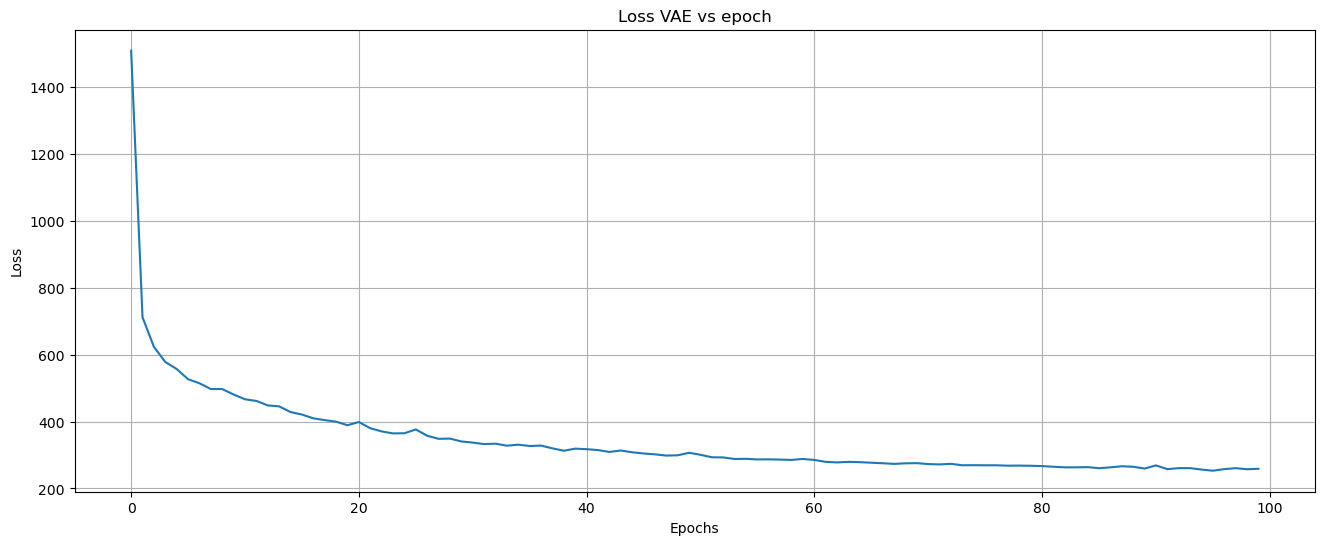

In [85]:
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(np.array(losses))
ax.set_title(f"Loss VAE vs epoch")
ax.set_xlabel(f"Epochs")
ax.set_ylabel(f"Loss")
ax.grid(True)
plt.show()

In [99]:
# sauve modèles

model_savepath = '/home/benjamin.deporte/MVA/MVA_ModelNet_VAE/models/'
torch.save(encoder, model_savepath+'encoder.pth')
torch.save(decoder, model_savepath+'decoder.pth')

### Visualize latent space

In [86]:
# get the first n_batches in the dataset
n_batches = 2

# set dataloader
mn40_converted_loader = DataLoader(
    modelnet10_converted,
    batch_size=batch_size,
    shuffle=True
)
data_iter = iter(mn40_converted_loader)

# form latent space
latent_tensor = torch.zeros((batch_size, latent_dim * 2))
all_labels = torch.zeros((batch_size))

# encode the first n_batches
for bn in range(n_batches):
    batch_ps, batch_label = next(data_iter)
    batch_ps = batch_ps.to(device)
    with torch.no_grad():
        encoded_batch = encoder(batch_ps)
        if bn==0:
            latent_tensor = encoded_batch
            all_labels = batch_label
        else:
            latent_tensor = torch.concatenate([latent_tensor, encoded_batch], axis=0)
            all_labels = torch.concatenate([all_labels, batch_label], axis=0)

Explained variance = [0.15603843 0.11956633 0.0848195 ]


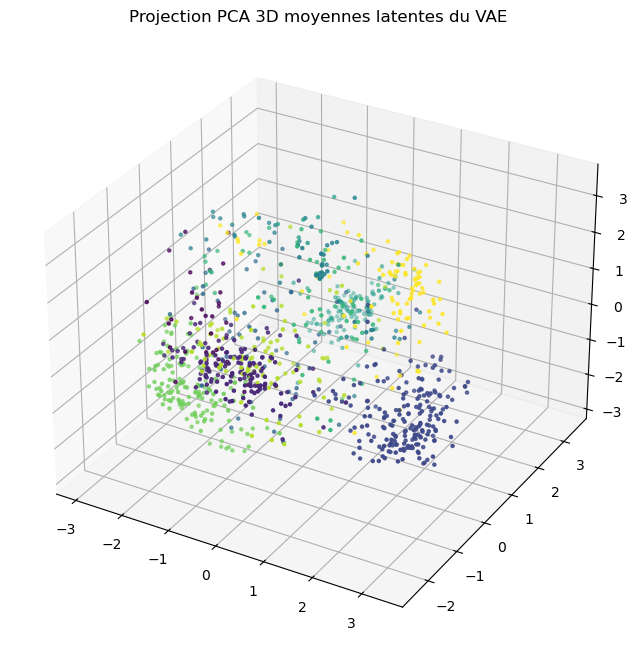

In [91]:
# get data
X = latent_tensor[:,:latent_dim].cpu().numpy()  # get mu's of the Gaussians
l = all_labels.numpy().reshape(-1,)

# form PCA
pca = PCA(n_components=3)
X_3D = pca.fit_transform(X)
print(f"Explained variance = {pca.explained_variance_ratio_}")

# # display
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection="3d")
ax.scatter(X_3D[:,0], X_3D[:,1], X_3D[:,2], marker='.', c=l)
ax.set_title(f"Projection PCA 3D moyennes latentes du VAE")
ax.grid(True)
plt.show()

In [92]:
df = pd.DataFrame(data=X_3D, columns=['X','Y','Z'])
fig = px.scatter_3d(df, x='X', y='Y', z='Z', opacity=0.2, symbol_sequence=['circle'], title=f"{PCA}", color=l)
fig.show()

### XPs - est-ce que la génération par le decoder peut faire de la scene completion ?

In [174]:
batch_size = 1

mn40_converted_loader = DataLoader(
    modelnet40_converted,
    batch_size=batch_size,
    shuffle=True
)

data_iter = iter(mn40_converted_loader)

batch_ps, batch_label = next(data_iter)

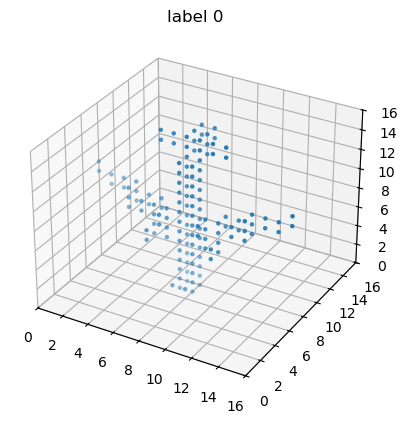

In [175]:
fig = display_3d_tensor(batch_ps[0,:], name=f"label {batch_label.item()}")

In [176]:
# encodage
encoded_batch = encoder(batch_ps.to(device))
mu_q = encoded_batch[:,:latent_dim]
sigma_q = nn.Softplus()(encoded_batch[:,latent_dim:])

# posterior
q_zgivenx = td.Independent(
    td.Normal(loc=mu_q, scale=sigma_q),
    reinterpreted_batch_ndims=1
)
print(f"posterior z|x = {q_zgivenx}")

# sampling K posterior samples
K = 5
z_sample_reparametrized = q_zgivenx.rsample((K,))
print(f"z_samples_reparametrized samplés = {z_sample_reparametrized.shape}")

# observation model
p_xgivenz = td.Independent(
    td.Bernoulli(logits = decoder(z_sample_reparametrized)), 
    reinterpreted_batch_ndims=3
)
print(f"observation models x|z = {p_xgivenz}")


posterior z|x = Independent(Normal(loc: torch.Size([1, 32]), scale: torch.Size([1, 32])), 1)
z_samples_reparametrized samplés = torch.Size([5, 1, 32])
observation models x|z = Independent(Bernoulli(logits: torch.Size([5, 1, 16, 16, 16])), 3)


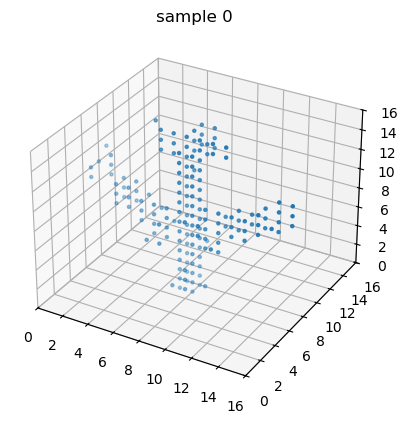

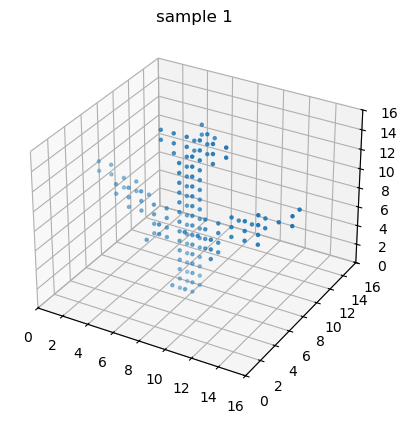

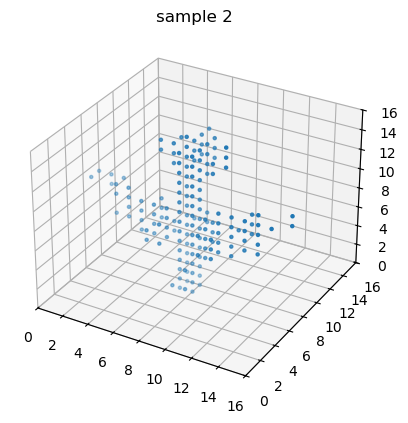

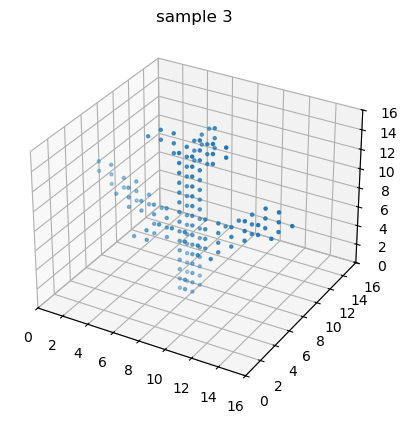

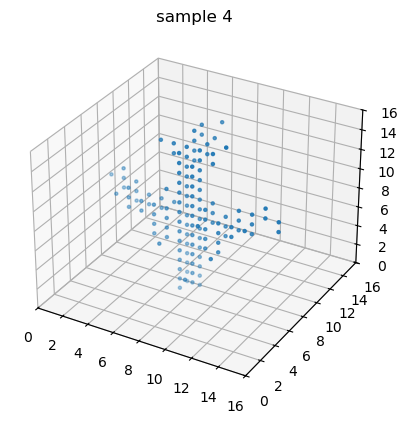

In [177]:
# display observation samples
xs = p_xgivenz.sample()

for i in range(K):
    batch_ps = xs[i,0]
    fig = display_3d_tensor(batch_ps, name=f"sample {i}")

### Performance de la génération quand on retire des points à l'image initiale ?